### Small Dataset: Voigt Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
from zipfile import ZipFile, ZIP_DEFLATED
from scipy.special import voigt_profile

In [2]:
np.random.seed(42) # for reproducibility
num_repetitions = 5000
num_xs = 11763
x = np.linspace(0, 10, num_xs)
dataset_type = 'smalldataset'

signals = np.zeros((num_repetitions, len(x)))
func_params = []

In [3]:
all_peaks = []

In [4]:
binary_peaks = np.zeros((num_repetitions, num_xs))

In [5]:
import math

In [6]:

for i in range(num_repetitions):
    n_func = np.random.randint(5, 10)
    signal = np.zeros(num_xs, )
    parameters = []
    peaks = []
    used_means = []

    for _ in range(n_func):

        attempts = 0

        while True:
            a = np.random.uniform(1,8) # peak center
            b = np.random.uniform(0.05,0.1) # half width half max (HWHM) for L
            # rule of thumb is 7 points per peak, maybe 5
            stddev = b / np.sqrt(2 * np.log(2)) # convert b to std dev
            mix_param = np.random.uniform (0.2,0.8)

            min_d = b * 4
            if all(abs(a - m) >= min_d for m in used_means):
                used_means.append(a)
                break
            attempts += 1
            if attempts > 200: # avoid inf loop
                break

        lor = (1 / math.pi) * (b / ((x - a)**2 + b**2))
        gau = np.exp(-((x - a)**2) / (2 * stddev ** 2))

        pseudo_V = mix_param * lor + (1 - mix_param) * gau

        signal += pseudo_V
        parameters.append((a, b, stddev, mix_param))

        peak_index = np.argmax(pseudo_V)
        peaks.append(peak_index)

        trim_min, trim_max = (a - (2*b) / 4, a + (2*b) / 4)

        # Create a boolean mask where x_values are between trim_min and trim_max
        trim_mask = (x >= trim_min) & (x <= trim_max)

        add_ones = np.where(trim_mask == True)[0]
        binary_peaks[i][add_ones] = 1

    signals[i] = signal
    func_params.append(parameters)
    all_peaks.append(peaks)

In [7]:
plt.close('all')

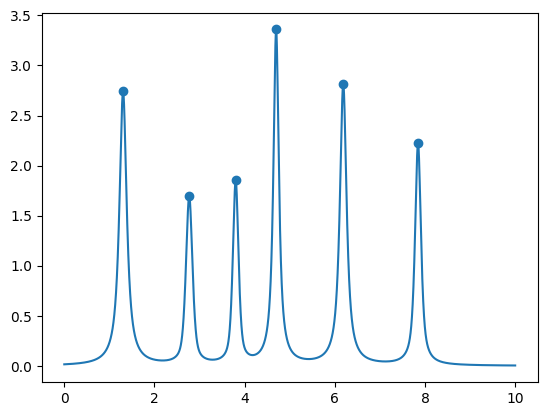

In [8]:
plt.figure()
i=15
plt.plot(x, signals[i])
plt.scatter(x[all_peaks[i]], signals[i][all_peaks[i]])
plt.show()

In [9]:
all_peaks[0]

[np.int64(9004),
 np.int64(2461),
 np.int64(8308),
 np.int64(1346),
 np.int64(2924),
 np.int64(3681),
 np.int64(7641),
 np.int64(6054)]

In [10]:
np.argmax(signals[0], axis=0)

np.int64(6054)

(5000, 11763)


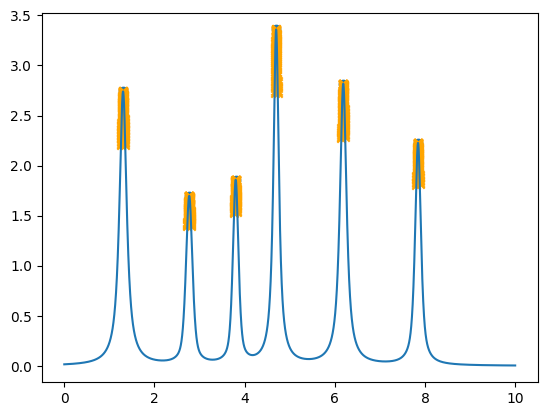

In [11]:
plt.figure()
i=15

print(binary_peaks.shape)

all_ones = np.where(binary_peaks[i] > 0)[0]
all_ones.shape

plt.plot(x, signals[i])
plt.scatter(x[all_peaks[i]], signals[i][all_peaks[i]])

plt.scatter(x[all_ones], signals[i][all_ones], marker='x', color='orange')

plt.show()


In [12]:
def add_noise_by_percentage(signal, noise_percentage):
        """
        Add random noise to a NumPy array based on a percentage of the maximum signal value.

        Parameters:
            signal (numpy.ndarray): The original signal array.
            noise_percentage (float): Percentage of the maximum signal value to use as noise.

        Returns:
            noisy_signal (numpy.ndarray): The signal array with added noise.
        """
        # Find the maximum value in the signal
        max_value = np.max(np.abs(signal))

        # Calculate the noise standard deviation as a percentage of the max signal value
        noise_std = (noise_percentage / 100) * max_value

        # Generate random Gaussian noise with zero mean and calculated standard deviation
        noise = np.random.normal(0.005, noise_std, signal.shape)

        # Add the noise to the original signal
        noisy_signal = signal + noise

        return noisy_signal

noisy_signal = add_noise_by_percentage(signals, 0.2)

In [13]:
ds = xr.Dataset(
    {
        "Intensities": (["pattern", "x"], noisy_signal),
        "BinaryArr": (["pattern", "x"], binary_peaks)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": np.linspace(1, 10, x.shape[0])
    },
    attrs={
        "description": "Simulated pseudo-Voigt signals with labeled peaks, padded with 1s along FWHM",
        "min_d_rule": "Minimum distance between peaks = 4 * b",
        "note": "Each pattern contains 5-10 total peaks. Used_means enforces peak spacing.",
        "mixing": "The mixing parameter is np.random.uniform(0.2,0.8) with a seed=42",
        "params": "a=np.random.uniform(1,8) b=np.random.uniform(0.05,0.1), seed=42",
        "noise": "True, 0.2%"
    }
)

In [14]:
intensities = ds["Intensities"].values
binary = ds["BinaryArr"].values

(5000, 11763)


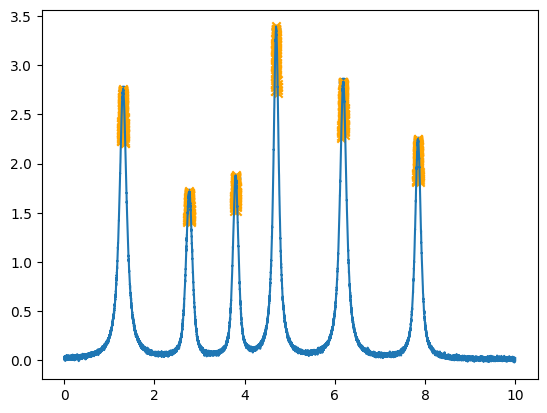

In [15]:
# Check that there is noise
plt.figure()

i=15

print(binary_peaks.shape)

all_ones = np.where(binary_peaks[i] > 0)[0]
all_ones.shape

plt.plot(x, intensities[i])
plt.scatter(x[all_peaks[i]], intensities[i][all_peaks[i]])

plt.scatter(x[all_ones], intensities[i][all_ones], marker='x', color='orange')

plt.show()


In [18]:
%matplotlib widget

In [16]:
plt.close('all')

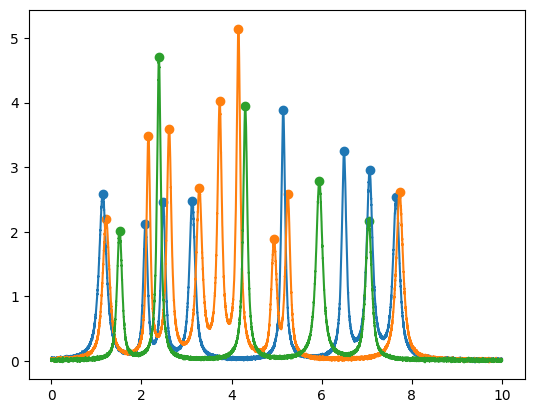

In [17]:
plt.figure()
for i in range(3):
    plt.plot(x, intensities[i])
    plt.scatter(x[all_peaks[i]], intensities[i][all_peaks[i]])
plt.show()

In [18]:
path = '../saved_data/'
file = f'psuedovoigt_functions_{dataset_type}_noisy_11763.nc'

ds.to_netcdf(os.path.join(path, file))
with ZipFile(os.path.join(path,file.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file), arcname=file)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import entropy

In [ ]:
ds = xr.open_dataset(path + file)

In [ ]:
gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
x = ds["x"].values
peak_idx = np.where(binary == 1)

In [ ]:
random_state = 42

In [ ]:
# Split data into train and test sets
gauss_train, gauss_test, binary_train, binary_test = train_test_split(gaussians, binary, test_size=0.2, random_state=random_state)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features (the intensity values)
scaler = MinMaxScaler() # create the scaler object 

gauss_train = scaler.fit_transform(gauss_train)
gauss_test = scaler.transform(gauss_test)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
# sample_weights = compute_sample_weight(class_weight='balanced', y=binary_train)

In [ ]:
# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(600), max_iter=1000, random_state=random_state, verbose=True,
                   learning_rate_init=0.001,  # Default is 0.001; can increase or decrease
                    tol=1e-5,
                   early_stopping=False)

In [ ]:
# Train the MLP classifier
mlp.fit(gauss_train, binary_train)

Iteration 1, loss = 227.44582327
Iteration 2, loss = 78.78433371
Iteration 3, loss = 61.54897539
Iteration 4, loss = 59.38965167
Iteration 5, loss = 57.46963420
Iteration 6, loss = 55.02463367
Iteration 7, loss = 52.10993535
Iteration 8, loss = 48.82655242
Iteration 9, loss = 45.30883408
Iteration 10, loss = 41.83006839
Iteration 11, loss = 38.57692735
Iteration 12, loss = 35.89583151
Iteration 13, loss = 33.62484420
Iteration 14, loss = 31.88318239
Iteration 15, loss = 30.55335440
Iteration 16, loss = 29.50292752
Iteration 17, loss = 28.64666872
Iteration 18, loss = 27.91482644
Iteration 19, loss = 27.36186065
Iteration 20, loss = 26.83589395
Iteration 21, loss = 26.37936031
Iteration 22, loss = 25.95412753
Iteration 23, loss = 25.59504506
Iteration 24, loss = 25.24428571
Iteration 25, loss = 24.94684044
Iteration 26, loss = 24.60012351
Iteration 27, loss = 24.33836299
Iteration 28, loss = 24.10175080
Iteration 29, loss = 23.81374399
Iteration 30, loss = 23.58284356
Iteration 31, loss

,hidden_layer_sizes,600
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


In [ ]:
binary_pred = mlp.predict(gauss_test) # make predictions

In [ ]:
probs = mlp.predict_proba(gauss_test)

In [ ]:
two_classprobs = np.array([[i,1-i] for i in probs]) # 1-i will give probability for the 0 class
two_classprobs = two_classprobs.reshape((probs.shape[0],probs.shape[1],2)) # reshape to (num_samples, num_features, num_classes)

In [ ]:
confidences = []
for i in range(two_classprobs.shape[0]):
    confidence = np.max(two_classprobs[i], axis=1) # returns max value for each of the features
    confidences.append(confidence)
confidences = np.array(confidences)

In [ ]:
uncertainties = []
for i in range(two_classprobs.shape[0]):
    uncertainties.append(entropy(two_classprobs[i].T))
uncertainties = np.array(uncertainties)

(array([307, 394]),)


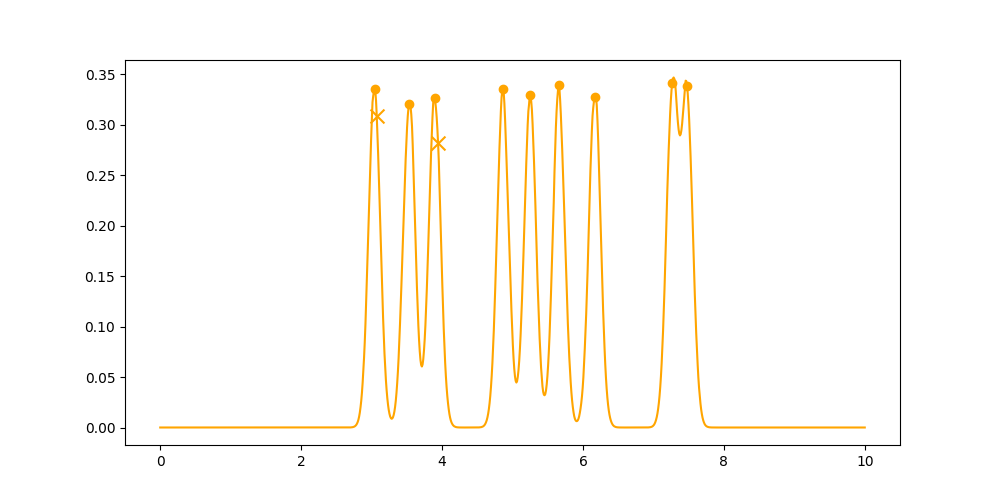

In [ ]:
plt.close()
# plt.scatter(x, uncertainties)
# plt.scatter(x, confidences)

plt.figure(figsize=(10,5))
colors = [
    'orange', 'red', 'green', 'blue', 'purple', 'brown', 'pink', 'gray',
    'olive', 'cyan', 'magenta', 'teal', 'gold', 'navy', 'lime', 'maroon',
    'turquoise', 'darkorange', 'darkgreen', 'indigo'
]


for i in range(1):
    
    idx_true = np.where(binary_test[i] == 1)
    plt.scatter(x[idx_true], gauss_test[i][idx_true], marker='o', color=colors[i])
    plt.plot(x, gauss_test[i], color=colors[i])

    idx = np.where(binary_pred[i] == 1)
    print(idx)
    plt.scatter(x[idx], gauss_test[i][idx], marker='x', s = 100, color=colors[i])
  
    
   
plt.show()

In [ ]:
%matplotlib widget

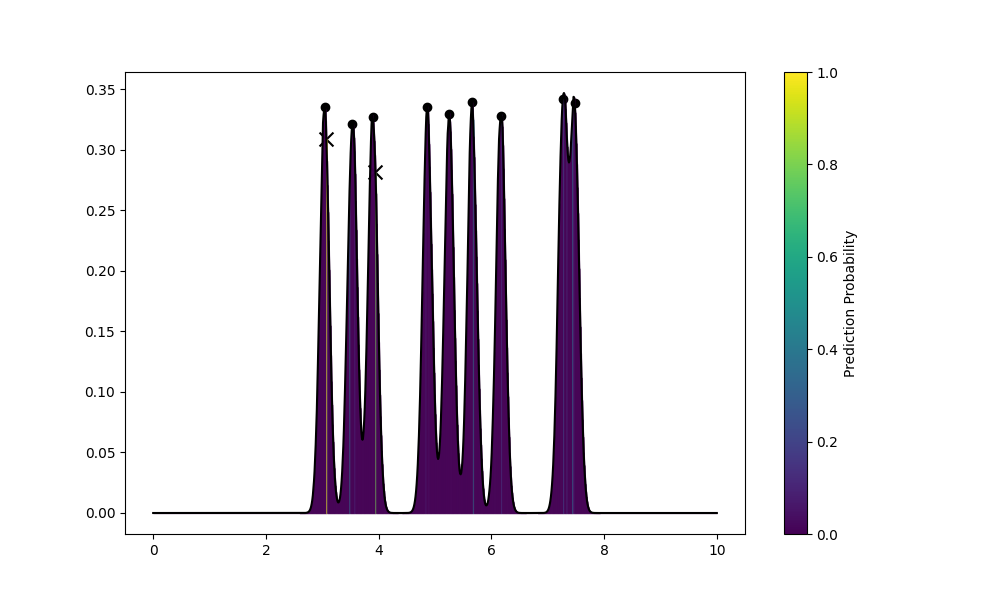

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

cmap = cm.viridis  # You can choose any colormap
norm = mcolors.Normalize(vmin=0, vmax=1)

plt.close()

plt.figure(figsize=(10,6))
# colors = [
#     'orange', 'red', 'green', 'blue', 'purple', 'brown', 'pink', 'gray',
#     'olive', 'cyan', 'magenta', 'teal', 'gold', 'navy', 'lime', 'maroon',
#     'turquoise', 'darkorange', 'darkgreen', 'indigo'
# ]

colors = ['black', 'black']

for i in range(1):
    # True peaks
    idx_true = np.where(binary_test[i] == 1)
    plt.scatter(x[idx_true], gauss_test[i][idx_true], marker='o', color=colors[i])

    # Full curve
    plt.plot(x, gauss_test[i], color=colors[i])

    # ML-predicted peaks
    idx = np.where(binary_pred[i] == 1)
    plt.scatter(x[idx], gauss_test[i][idx], marker='x', s=100, color=colors[i])
    
    # Shade under the curve with color based on prediction probabilities
    for j in range(len(x)-1):
        plt.fill_between(x[j:j+2], gauss_test[i][j:j+2], color=cmap(norm(probs[i][j])), alpha=0.6)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Prediction Probability')

plt.show()

In [ ]:
# the gaussians are going negative; might be issue in how they're being added
# might be necessary to do convolution
# np.convolve(array1, array2)

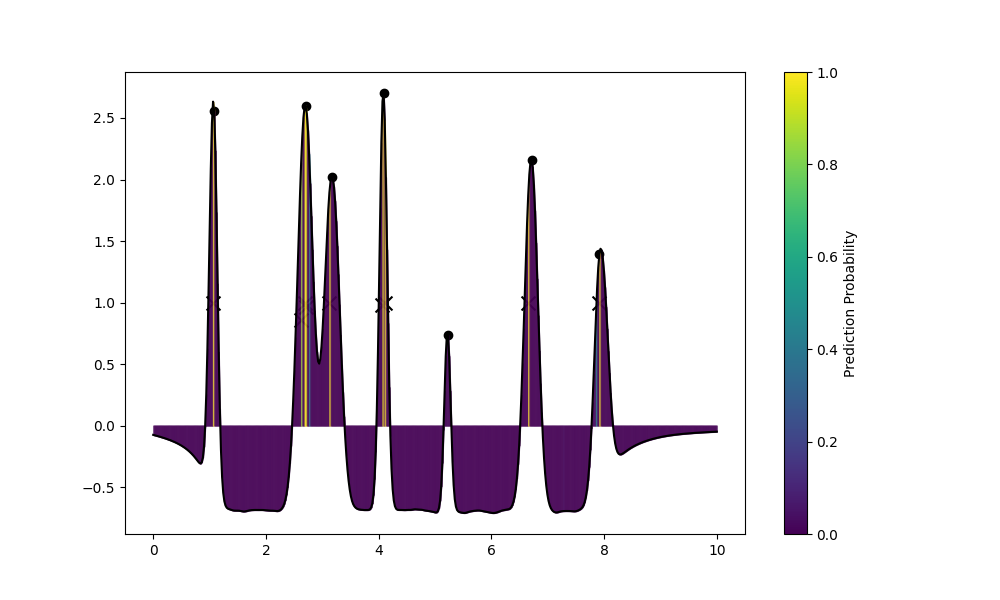

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

cmap = cm.viridis  # You can choose any colormap
norm = mcolors.Normalize(vmin=0, vmax=1)

plt.close()

plt.figure(figsize=(10,6))

colors = ['black', 'black']

for i in range(1,2):
    # True peaks
    idx_true = np.where(binary_test[i] == 1)
    plt.scatter(x[idx_true], gauss_test[i][idx_true], marker='o', color=colors[i])

    # Full curve
    plt.plot(x, gauss_test[i], color=colors[i])

    # ML-predicted peaks
    idx = np.where(binary_pred[i] == 1)
    plt.scatter(x[idx], probs[i][idx], marker='x', s=100, color=colors[i])
    
    # Shade under the curve with color based on prediction probabilities
    for j in range(len(x)-1):
        plt.fill_between(x[j:j+2], gauss_test[i][j:j+2], color=cmap(norm(probs[i][j])), alpha=0.6)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Prediction Probability')

plt.show()

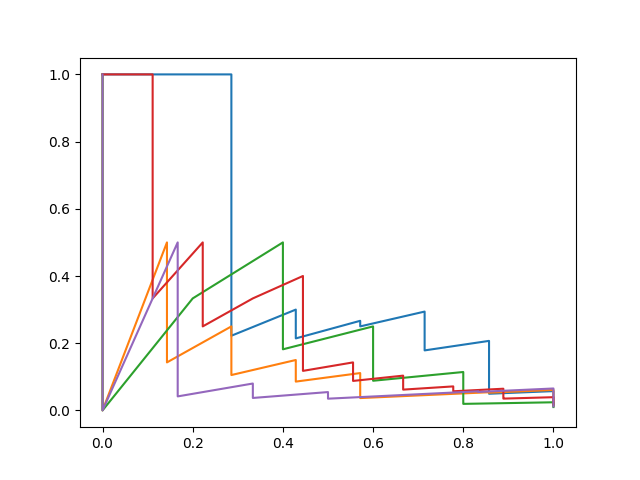

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.close()
num_test_samples = binary_test.shape[1]
plt.figure()
for i in range(min(num_test_samples, 5)):

    precision, recall, thresholds = precision_recall_curve(binary_test[i, :], probs[i,:])
    avg_prec = average_precision_score(binary_test[i, :], probs[i,:])
    plt.plot(recall, precision)

plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [ ]:
rf = RandomForestClassifier(n_estimators=300,
                        max_depth=None,
                        verbose=3,
                        class_weight="balanced",
                        n_jobs=-1,
                        random_state=42)

In [ ]:
rf.fit(gauss_train, binary_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 2 of 300
building tree 14 of 300
building tree 16 of 300
building tree 13 of 300
building tree 12 of 300
building tree 11 of 300
building tree 15 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   47.0s


building tree 114 of 300
building tree 115 of 300
building tree 116 of 300
building tree 117 of 300
building tree 118 of 300
building tree 119 of 300
building tree 120 of 300
building tree 121 of 300
building tree 122 of 300
building tree 123 of 300
building tree 124 of 300
building tree 125 of 300
building tree 126 of 300
building tree 127 of 300
building tree 128 of 300
building tree 129 of 300
building tree 130 of 300
building tree 131 of 300
building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.9min


building tree 273 of 300
building tree 274 of 300
building tree 275 of 300
building tree 276 of 300
building tree 277 of 300
building tree 278 of 300
building tree 279 of 300
building tree 280 of 300
building tree 281 of 300
building tree 282 of 300
building tree 283 of 300
building tree 284 of 300
building tree 285 of 300
building tree 286 of 300
building tree 287 of 300
building tree 288 of 300
building tree 289 of 300
building tree 290 of 300
building tree 291 of 300
building tree 292 of 300
building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300


In [ ]:
binary_pred = rf.predict(gauss_test) # make predictions

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  36 out of  50 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.4s finished


(array([], dtype=int64),)
(array([], dtype=int64),)


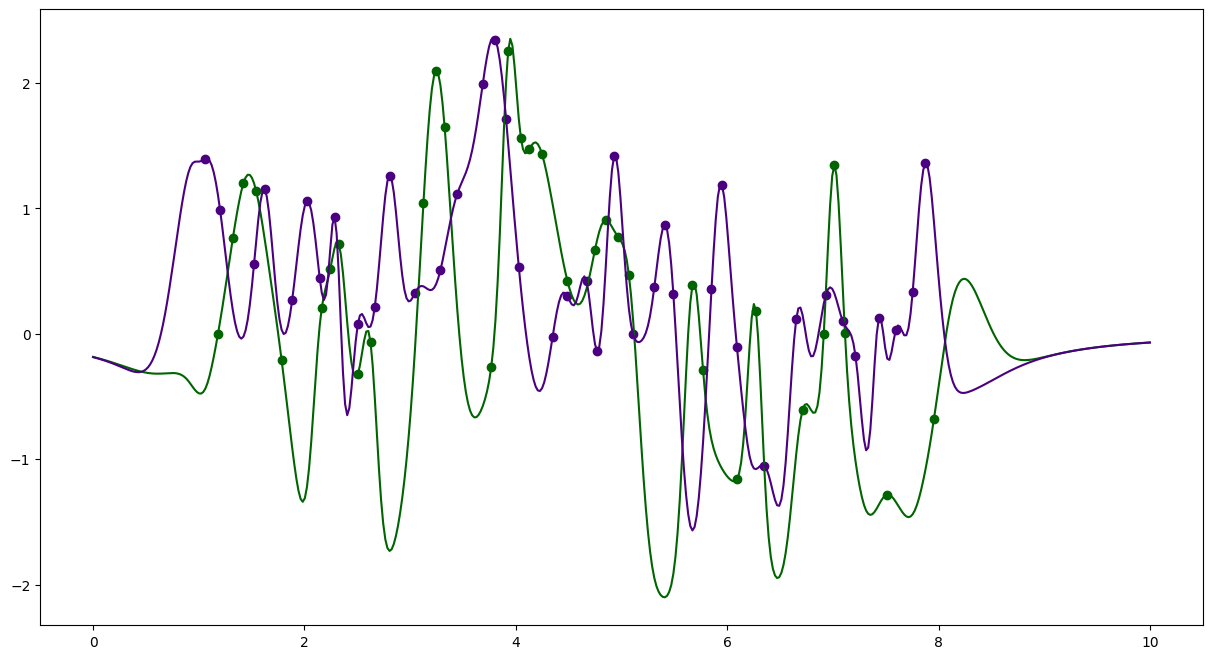

In [ ]:
plt.close()
# plt.scatter(x, uncertainties)
# plt.scatter(x, confidences)

plt.figure(figsize=(15,8))
colors = [
    'orange', 'red', 'green', 'blue', 'purple', 'brown', 'pink', 'gray',
    'olive', 'cyan', 'magenta', 'teal', 'gold', 'navy', 'lime', 'maroon',
    'turquoise', 'darkorange', 'darkgreen', 'indigo'
]


for i in range(18,20):
    
    idx_true = np.where(binary_test[i] == 1)
    plt.scatter(x[idx_true], gauss_test[i][idx_true], marker='o', color=colors[i])
    plt.plot(x, gauss_test[i], color=colors[i])

    idx = np.where(binary_pred[i] == 1)
    print(idx)
    plt.scatter(x[idx], gauss_test[i][idx], marker='x', s = 100, color=colors[i])
  
    
   
plt.show()

In [ ]:
# Plotting a few patterns with the probability of label = 1 ("is a peak") as a shaded region.
# You can use a second y-axis on the right for this probability (0 - 1). These will show if
# 1) peaks are generally being found in the vicinity of a peak and 2) if the boundary for
# "is a peak" needs to be adjusted.